## Imports

In [1]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 6month 4w 2d


In [2]:

import sys
import os
sys.path.append('../src')
#%pip install -r requirements.txt
from data_preprocessing import data_preprocessing_tumor
from model import BrainCNN, EarlyStopping


import torch
import pickle
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [3]:
train_loader, test_loader = data_preprocessing_tumor()
print("data was successfully loaded")

100%|██████████| 149M/149M [00:04<00:00, 33.7MB/s] 

Extracting files...


['pituitary', 'notumor', 'meningioma', 'glioma']
['pituitary', 'notumor', 'meningioma', 'glioma']
data was successfully loaded


In [ ]:
print(f"Train dataset size: {len(train_loader.dataset)}")
#print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Train dataset size: 5712
Test dataset size: 1311


In [5]:
from collections import defaultdict

def count_images_per_class(loader):
    class_counts = defaultdict(int)

    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1 

    return class_counts

train_class_counts = count_images_per_class(train_loader)
test_class_counts = count_images_per_class(test_loader)

print("Train loader class counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} images")

print("\nTest loader class counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} images")


Train loader class counts:
Class 3: 1457 images
Class 1: 1339 images
Class 2: 1595 images
Class 0: 1321 images

Test loader class counts:
Class 0: 300 images
Class 1: 306 images
Class 2: 405 images
Class 3: 300 images


In [6]:

""" 
first try paper CCE, then NLLLoss
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()



>>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
>>> optimizer.zero_grad()
>>> loss_fn(model(input), target).backward()
>>> optimizer.step()
    def train(model, train_loader, valid_loader, ):

"""



""" 
important

2 combinations should be tested:
1. last layer Softmax + loss func nn.NLLLoss
2. no last layer and CrossEntropyLoss
"""


' \nimportant\n\n2 combinations should be tested:\n1. last layer Softmax + loss func nn.NLLLoss\n2. no last layer and CrossEntropyLoss\n'

In [7]:
# Hyperparameters

num_epochs=50
patience=1
learning_rate=0.001
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BrainCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5, delta=0.01)

# Metrics for runtime calculations

train_loss_metr = []
val_loss_metr = []

train_acc_metr = []
val_acc_metr = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_targets = []
    val_preds = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
            
            val_targets.extend(target.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct_val / total_val
    
    train_loss_metr.append(train_loss)
    val_loss_metr.append(val_loss)
    train_acc_metr.append(train_acc)
    val_acc_metr.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    early_stopping(val_loss, model)
    """ if early_stopping.early_stop:
        print("Early stopping")
        break """



torch.save(model.state_dict(), "./braincnn_prototype.weights")

Epoch 1: Train Loss: 0.7890, Val Loss: 0.6032
Epoch 2: Train Loss: 0.4625, Val Loss: 0.5056
Epoch 3: Train Loss: 0.3195, Val Loss: 0.3912
Epoch 4: Train Loss: 0.2347, Val Loss: 0.3004
Epoch 5: Train Loss: 0.1686, Val Loss: 0.2568
Epoch 6: Train Loss: 0.1047, Val Loss: 0.7140
Epoch 7: Train Loss: 0.0657, Val Loss: 0.2191
Epoch 8: Train Loss: 0.0414, Val Loss: 0.1290
Epoch 9: Train Loss: 0.0267, Val Loss: 0.1196
Epoch 10: Train Loss: 0.0154, Val Loss: 0.1234
Epoch 11: Train Loss: 0.0121, Val Loss: 0.0984
Epoch 12: Train Loss: 0.0101, Val Loss: 0.0999
Epoch 13: Train Loss: 0.0102, Val Loss: 0.1051
Epoch 14: Train Loss: 0.0071, Val Loss: 0.1009
Epoch 15: Train Loss: 0.0057, Val Loss: 0.1110
Epoch 16: Train Loss: 0.0046, Val Loss: 0.0965
Epoch 17: Train Loss: 0.0044, Val Loss: 0.0883
Epoch 18: Train Loss: 0.0037, Val Loss: 0.0953
Epoch 19: Train Loss: 0.0033, Val Loss: 0.1071
Epoch 20: Train Loss: 0.0032, Val Loss: 0.1078
Epoch 21: Train Loss: 0.0029, Val Loss: 0.0992
Epoch 22: Train Loss: 

In [10]:
early_stopping.load_best_model(model)

# Final evaluation on the test set
model.eval()
correct = 0
total = 0
test_targets = []
test_preds = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        test_targets.extend(target.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')




accuracy = test_accuracy  # уже посчитано выше
precision = precision_score(test_targets, test_preds, average='weighted')
recall = recall_score(test_targets, test_preds, average='weighted')
f1 = f1_score(test_targets, test_preds, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

with open("training_metrics.pkl", "wb") as f:
    pickle.dump({
        "train_loss": train_loss_metr,
        "val_loss": val_loss_metr,
        "train_acc": train_acc_metr,
        "val_acc": val_acc_metr,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }, f)

torch.save(model.state_dict(), "./braincnn_prototype.weights")

Accuracy of the model on the test images: 96.72%
Accuracy: 96.72%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


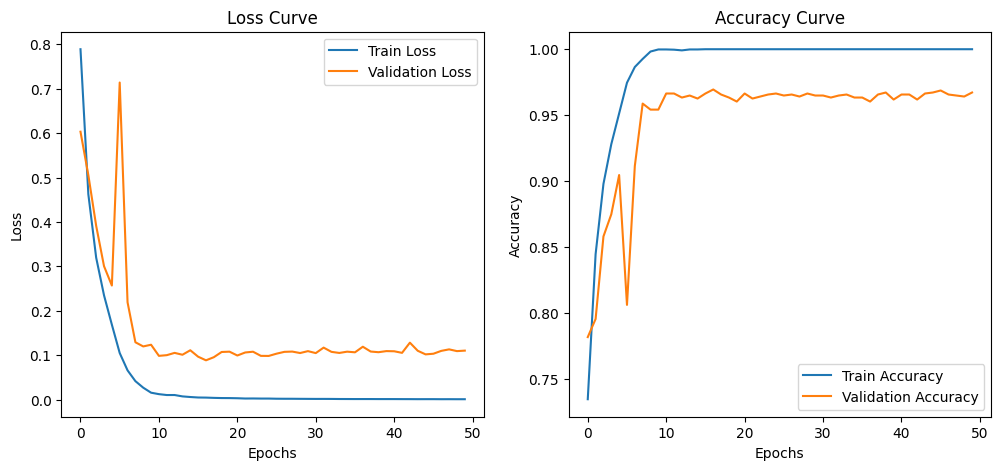

In [11]:
# Load metrics
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_loss_metr = metrics["train_loss"]
val_loss_metr = metrics["val_loss"]
train_acc_metr = metrics["train_acc"]
val_acc_metr = metrics["val_acc"]

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_metr, label='Train Loss')
plt.plot(val_loss_metr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_metr, label='Train Accuracy')
plt.plot(val_acc_metr, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.savefig("training_plots.png", dpi=300, bbox_inches="tight")  # Сохранение в файл
plt.show()
